# 

In [1]:
!pip install mauve-text
!pip install transformers
from parameter_tuning import train_model
from rnn_gaussian import PredictTime
import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
import numpy as np
from evaluation import evaluate_model, bin_plot
import random
from data_gen import Datagen

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device:  cuda


/home/kentagent/master_thesis_code/RNN/data_gen.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = df.max()[0]


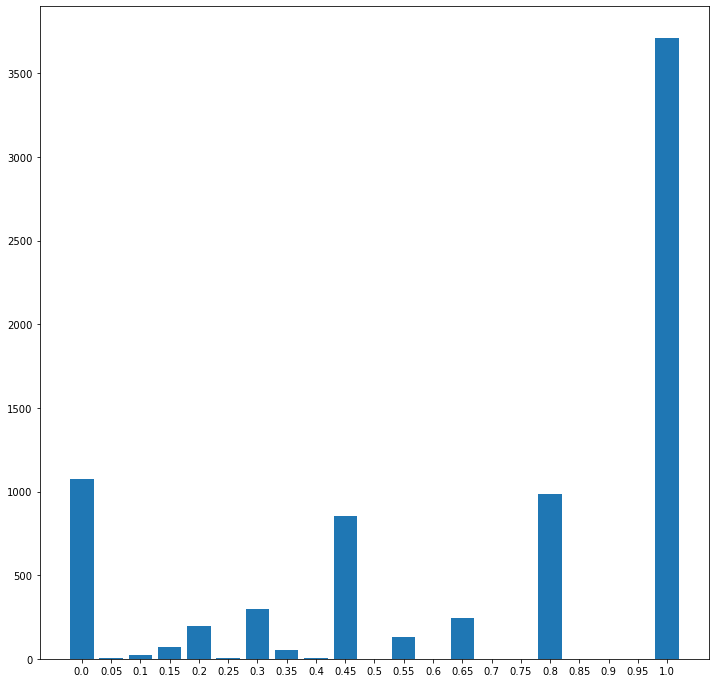

In [2]:
gen = Datagen(device)

x, y = gen.get_true_data(10)


bin_plot(y, 0, 1, None, 0.05)


In [3]:
import random

# Hyperparameters
sequence_length = [2*i for i in range(4,16)] # 2-20 increments of two
hidden_layers = [1,2]*10 # 1 and 2
hidden_1 = [2**i for i in range(5,10)] # 2^4 to 2^9
hidden_2 =[2**i for i in range(2, 5)] # 2^2 to 2^5
variance = [0.001, 0.01, 0.005, 0.05]
lr = [0.001, 0.01, 0.1, 0.005] # stop at 0.005
data_probability = [i/5 for i in range(1,6)]
noise_in_model = [True, False]
epochs = 1
optimizer = [optim.Adam, optim.SGD]
print(hidden_layers)

options = []

for seq_len in sequence_length:
    for layers in hidden_layers:
        for h1 in hidden_1:
            for h2 in hidden_2:
                for l in lr:
                    for v in variance:
                        for p in data_probability:
                            for n in noise_in_model:
                                entry = {}
                                entry["seq_len"] = seq_len
                                entry["layers"] = layers
                                entry["hidden1"] = h1
                                entry["hidden2"] = h2
                                entry["l"] = l
                                entry["variance"] = v
                                entry["data_prob"] = p
                                entry["noise_model"] = n
                                options.append(entry)
                
                                         
random.shuffle(options)    



[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]


In [4]:
from IPython.display import clear_output

best_model = None
best_history = [""]
best_config = None
best_score = 1
for entry in options:
    x_d, y_d = gen.get_generated_data(entry["seq_len"], entry["variance"], entry["data_prob"])
    x_t, y_t = gen.get_true_data(entry["seq_len"])
    x_val, y_val = gen.get_test_data(entry["seq_len"])
    
    model = PredictTime(input_size=1,
                        output_size=y_d[0].size()[0],
                        hidden_layers=entry["layers"],
                        h1=entry["hidden1"],
                        h2=entry["hidden2"],
                        device=device,
                       noise=entry["noise_model"]).to(device)
    print(x_d[0])
    print("Running model: ", entry, " epochs: ", epochs)

    
    model, history = train_model(model=model,
                                 x_data=x_d,
                                 y_data=y_d,
                                 batch_size=100,
                                 epochs=epochs,
                                 loss=nn.MSELoss(),
                                 optimizer=optim.Adam)
    clear_output()
    if history[-1][1] < best_score:
        print("New best model:\nNew loss: ", history[-1], "\nOld loss:", best_history[-1], "\nHistory:" , history[-10:])
        best_model = model
        best_history = history
        best_score = history[-1][1]
        best_config = entry
        evaluate_model(best_model, x_t, y_t,x_val,y_val, entry)
    else:
        evaluate_model(model, x_t, y_t,x_val,y_val, entry)
        print("Old model still stands:\nCurrent loss: ", history[-1], "\nBest loss:", best_history[-1])
                                 

    

New best model:
New loss:  [0, tensor(0.0702), tensor(0.1584)] 
Old loss:  
History: [[0, tensor(0.0702), tensor(0.1584)]]
[352.1646728515625, 354.77655029296875, 354.7879638671875, 351.01025390625, 352.75750732421875, 353.88360595703125, 355.4496765136719, 356.5161437988281, 352.6734313964844, 355.1793212890625, 353.1701965332031]


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


AttributeError: 'FloatProgress' object has no attribute 'style'

#### 